In [159]:
import numpy as np
from numpy import pi
from 
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.visualization.utils import _get_layered_instructions

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Additional imports for audio
from time import sleep
import matplotlib.pyplot as plt
from IPython.display import Audio, display, clear_output
from ipywidgets import widgets
from functools import partial
%matplotlib inline

ibmqfactory.load_account:WARNING:2021-05-18 11:35:35,695: Credentials are already in use. The existing account in the session will be replaced.


In [83]:
"""Plays a note from each column of the circuit"""

'Plays a note from each column of the circuit'

In [155]:
"""Global variables and utility functions"""

# Simulators
state_vector_sim = Aer.get_backend('statevector_simulator')
unitary_sim = Aer.get_backend('unitary_simulator')

# Utility functions
def get_state_vector(circuit):
    return state_vector_sim.run(circuit).result().get_statevector()

def get_unitary_matrix(circuit):
    return execute(circuit, unitary_sim).result().get_unitary()

def get_amplitudes(matrix):
    return abs(matrix)

def get_probabilities(matrix):
    return abs(matrix**2)

def get_phases(matrix):
    return np.angle(matrix)

# Pretty-printing
def print_matrix(matrix):
    print('Matrix shape ', matrix.shape)
    for row in matrix:
        for num in row:
            print(f"{np.around(num, 2)}   ", end='')
        print('')
    print('\n---')
    
def print_vector(vector, comment=''):
    print(f'Vector {comment} with shape {vector.shape}')
    for num in vector:
        print(np.around(num, 2))
    print('---')
    
def get_circuits_by_column(circuit):
    """circuit-splitter.ipynb"""
    # Get circuit metadata
    num_qubits = circuit.num_qubits
    num_clbits = circuit.num_clbits
    _, _, ops = _get_layered_instructions(circuit)
    num_columns = len(ops)
    
    # Initialize column information
    curr_column = [0] * num_qubits
    columns = []
    for i in range(num_columns):
        columns.append([])
        
    # Organize instructions by column
    for (insn, qargs, cargs) in circuit.data:    
        col = -1
        anchor_qubit = -1
        for qubit in qargs:
            index = qubit.index
            if curr_column[index] > col:
                col = curr_column[index]
                anchor_qubit = index
        if col == -1 or anchor_qubit == -1:
            print('Something went wrong...')
            continue

        columns[col].append((insn, qargs, cargs))
        curr_column[anchor_qubit] += 1
        for qubit in qargs:
            index = qubit.index
            curr_column[index] = curr_column[anchor_qubit]
        
    # Build the subcircuits by column
    sub_circuits = []
    for col in range(0, num_columns):
        sub_circuit = QuantumCircuit(num_qubits, num_clbits)
        for (insn, qargs, cargs) in columns[col]:
            sub_circuit.append(insn, qargs, cargs)
        sub_circuits.append(sub_circuit)

    assert len(sub_circuits) == num_columns
    return sub_circuits

"""Audio variables and functions"""
def synth(frequency):
    rate = 16000.0
    duration = 0.25
    x = np.linspace(0.0, duration, int(rate * duration))

    y = np.sin(frequency * 2.0 * np.pi * x)
    display(Audio(y, rate=rate, autoplay=True))

# Start with middle C = C4
# Each note increments by a phase of pi/4
# https://pages.mtu.edu/~suits/notefreqs.html#:~:text=Frequencies%20of%20Musical%20Notes%2C%20A4%20%3D%20440%20Hz
c_scale = {
    round(0, 2): ('C4', 261.63),
    round(pi/4, 2): ('D4', 293.66),
    round(2*pi/4, 2): ('E4', 329.63),
    round(3*pi/4, 2): ('F4', 349.23),
    round(4*pi/4, 2): ('G4', 392.00),
    round(-pi/4, 2): ('A4', 440.00), # after pi, phases are negative
    round(-2*pi/4, 2): ('B4', 493.88),
    round(-3*pi/4, 2): ('C5', 523.25)
}

def get_note(phase):
    """Return music note given a phase"""
    # Round to the nearest multiple of pi/4
    base = pi/4
    key = round(base * round(phase/base), 2)
    if key not in c_scale:
        print(f'{key} not in scale!')
        return None
    
    return c_scale[key]

def get_notes(state_vector):
    notes = []
    phases = get_phases(state_vector)
    for phase in phases:
        notes.append(get_note(phase))
    
    return notes

def play_notes(notes):
    """Notes is a list of tuples of form (note_name, frequency)"""
    for (note, frequency) in notes:
        synth(frequency)
        

In [113]:
# Test get_note()
phases_c_scale = [
    (0, 'C4'),
    (pi/4, 'D4'),
    (pi/2, 'E4'),
    (-pi/4, 'A4'),
    (-pi/2, 'B4')
]
for (phase, note_name) in phases_c_scale:
    note = get_note(phase)
    print(f'Got {note[0]}, expected {note_name}')
    print('Correct? ', note[0] == note_name)

Got C4, expected C4
Correct?  True
Got D4, expected D4
Correct?  True
Got E4, expected E4
Correct?  True
Got A4, expected A4
Correct?  True
Got B4, expected B4
Correct?  True


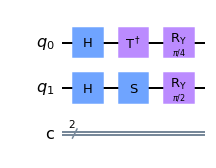

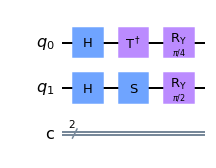

In [114]:
"""Insert circuit in this cell"""

qasm = """
OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];
creg c[2];

h q[0];
h q[1];
tdg q[0];
s q[1];
ry(pi/4) q[0];
ry(pi/2) q[1];
"""

circuit = QuantumCircuit.from_qasm_str(qasm)
circuit.draw()

In [121]:
# Get circuits by column
sub_circuits = get_circuits_by_column(circuit)

<ipython-input-120-a9a4f5f941bf>:57: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  index = qubit.index
<ipython-input-120-a9a4f5f941bf>:68: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  index = qubit.index


In [130]:
# Use first column as the starting state vector
state_vector = get_state_vector(sub_circuits[0])
print_vector(state_vector)

print_vector(get_phases(state_vector), comment='phases')
print_vector(get_probabilities(state_vector), comment='probabilities')

Vector  with shape (4,)
(0.5+0j)
(0.5+0j)
(0.5+0j)
(0.5+0j)
---
Vector phases with shape (4,)
0.0
0.0
0.0
0.0
---
Vector probabilities with shape (4,)
0.25
0.25
0.25
0.25
---


In [163]:
# Iterate through circuit
prev_state_vector = get_state_vector(sub_circuits[0])
for i in range(1, len(sub_circuits)):
    print(f'Column {i}')
    sub_circuit = sub_circuits[i]
    unitary_matrix = get_unitary_matrix(sub_circuit)
    
    # Multiply this column's unitary matrix with previous state_vector
    state_vector = np.matmul(unitary_matrix, prev_state_vector)
    print_vector(state_vector, comment='state')
    print_vector(get_phases(state_vector), comment='phases')
    print_vector(get_probabilities(state_vector), comment='probabilities')
    
    notes = get_notes(state_vector)
    print('notes', notes)
    
    # Sounds horrible!
    play_notes(notes)
        
    # Update this state vector to next iteration's prev_state_vector
    prev_state_vector = state_vector
        
    print('\n')

Column 1
Vector state with shape (4,)
(0.5+0j)
(0.35-0.35j)
0.5j
(0.35+0.35j)
---
Vector phases with shape (4,)
0.0
-0.79
1.57
0.79
---
Vector probabilities with shape (4,)
0.25
0.25
0.25
0.25
---
notes [('C4', 261.63), ('A4', 440.0), ('E4', 329.63), ('D4', 293.66)]


Column 2
Vector state with shape (4,)
(0.33-0.14j)
(0.14-0.6j)
(0.14+0.33j)
(0.6+0.14j)
---
Vector phases with shape (4,)
-0.39
-1.35
1.18
0.22
---
Vector probabilities with shape (4,)
0.13
0.37
0.12
0.38
---
notes [('C4', 261.63), ('B4', 493.88), ('E4', 329.63), ('C4', 261.63)]
